In [32]:
import sys
import librosa as lr
import librosa.display as lrd
import numpy as np

import matplotlib.pyplot as plt
import IPython.display as ipd

%matplotlib inline

sys.path.append("../libs/")
from processing import make_fragments, unmake_fragments, s_to_power, power_to_s

In [33]:
def P2R(radii, angles):
    return radii * np.exp(1j*angles)

def R2P(x):
    return np.abs(x), np.angle(x)

In [34]:
n_fft = 512
win = n_fft
hop = win // 4

x, sr = lr.load('/data/riccardo_datasets/npr_news/train/newscast230841.wav', sr=None, duration=2, offset=2)
s = lr.stft(x, n_fft=n_fft, hop_length=hop, win_length=win)

print(x.shape)
print(s.shape)

(32000,)
(257, 251)


In [41]:
frag_hop = lr.time_to_frames(0.15, sr=sr, hop_length=hop, n_fft=win)
frag_win = lr.time_to_frames(0.275, sr=sr, hop_length=hop, n_fft=win)
print(frag_hop, frag_win)

s_power = s_to_power(s)
_, phase = R2P(s)
frags = np.array(make_fragments(s_power, frag_hop_len=frag_hop, frag_win_len=frag_win))

# APPLY NOISE TO FRAGs!!!
sh = frags.shape
#frags[:3] += np.random.randn(*sh[1:])*0.5

print(frags.shape)

16 32
(14, 256, 32, 1)


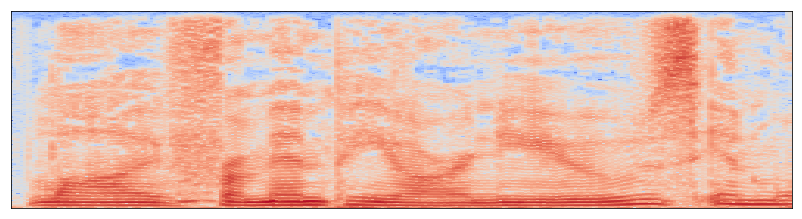

In [42]:
plt.figure(figsize=(14, 8))
plt.subplot(211)
lrd.specshow(lr.power_to_db(np.abs(s)))
ipd.Audio(x, rate=sr)


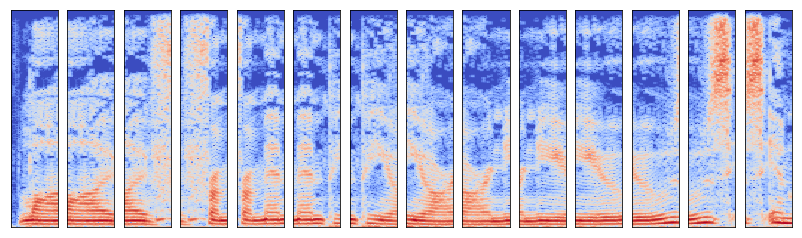

In [43]:
plt.figure(figsize=(14, 4))
n = frags.shape[0]
for i in range(n):
    plt.subplot(1,n,1+i)
    lrd.specshow(lr.power_to_db(np.abs(frags[i,...,0])))
    # ipd.Audio(x, rate=sr)

In [44]:
def unmake_fragments(s_frag, frag_hop_len, frag_win_len):
    # store input shape
    in_shape = s_frag.shape
    print(s_frag.shape)
    # TODO get to work with arbitrary input shape?
    spec_length = (in_shape[0]-1) * frag_hop_len + frag_win_len
    output_shape = (in_shape[1], spec_length, in_shape[-1]) if len(in_shape) == 4 else (in_shape[1], spec_length)
    print(output_shape)
    s = np.zeros(output_shape, dtype=s_frag.dtype)
    for i, frag in enumerate(s_frag):
        # NOTE this uses the initial portion of each fragment
        lower_bound = i*frag_hop_len
        upper_bound = i*frag_hop_len+frag_win_len
        s[:, lower_bound:upper_bound] = frag
    return s

In [45]:
s_power_sig = unmake_fragments(frags, frag_hop_len=frag_hop, frag_win_len=frag_win)

s_sig_abs = power_to_s(np.abs(s_power_sig))
s_sig_len = s_sig_abs.shape[1]
s_sig = P2R(s_sig_abs, phase[:,:s_sig_len])
print(s_sig.shape)
sig = lr.istft(s_sig, hop_length=hop, win_length=win)


(14, 256, 32, 1)
(256, 240, 1)
(257, 240)


(257, 240)


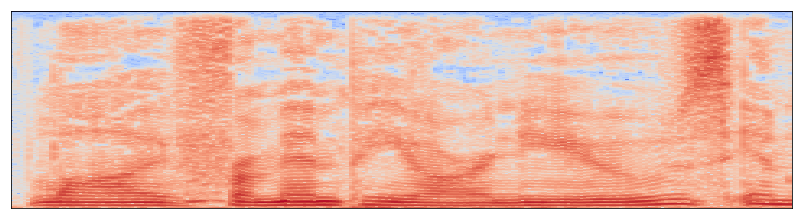

In [46]:
plt.figure(figsize=(14, 8))
plt.subplot(211)
print(s_sig.shape)
lrd.specshow(lr.power_to_db(np.abs(s_sig)))
ipd.Audio(sig, rate=sr)

In [30]:
#